Citation

In [7]:
import os, shutil, csv,math,scipy,time
from datetime import datetime

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
#displaying data
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow,figure
import matplotlib.image as mpimg
import tifffile as tif
plt.rcParams['figure.dpi'] = 150 
%matplotlib inline
#TF imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from keras import backend as K 
temp_weights=r'D:\Training_Data_Creation\01-logs\temp.h5'
'''TF code to tell TF version, GPU detected, and limit memory growth'''
print(f"Tensorflow ver. {tf.__version__}")
#physical_device = tf.config.experimental.list_physical_devices('GPU')
#print(f'Device found : {physical_device}')
#tf.config.experimental.get_memory_growth(physical_device[0])

Tensorflow ver. 2.8.0


## Loading input tiff and making blank prediction image

In [8]:
input_img=tif.imread(r'E:\GIS\Thesis\Intermediate Data\Large_Imagery\S2_Paper_C8_AOI.tif')

## Loading DNN

In [9]:
NN_name='NN4'
with tf.device('/cpu:0'):
    def Dense_NN(lr,u,u2,u3,u4): # the last tested. good for more data.
        model=Sequential()
        model.add(Dense(u, activation='relu', input_shape=[9]))
        model.add(Dense(u2, activation='relu'))
        model.add(Dense(u3, activation='relu'))
        model.add(Dense(u4, activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss= "MeanAbsoluteError",
                      optimizer=keras.optimizers.Adam(learning_rate=lr),
                      metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanSquaredError()])
        return model
    path_to_weights=r'D:\Training_Data_Creation\01-logs\Best_dnn\01SELECTEDNN4_1000bs_2-0.05139mae-1012r-[225, 0.001, 16, 16, 32, 40]p-66.64sec\Weights-0.05139_11182022_070752.h5'
    lr,u,u2,u3,u4= 0.001, 16, 16, 32,40
    model=Dense_NN(lr,u,u2,u3,u4)
    model.load_weights(path_to_weights)
    print('model loaded with weights')

model loaded with weights


### Define output with meaningful name

In [10]:
out_img=r'E:\GIS\Thesis\Intermediate Data\Large_Imagery\s2_c8{}pred_output.tif'.format(NN_name)

### Displaying blue band and prediction image

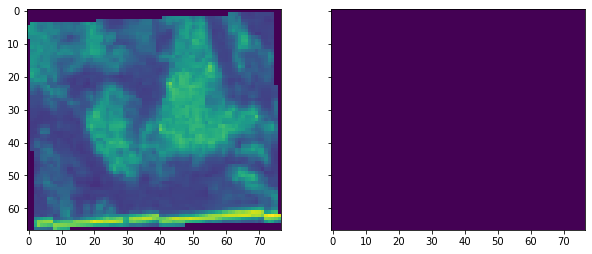

5159 total number of pixels
(67, 77, 9) input shape, (67, 77, 1) output shape


In [11]:
Y_b,X_b,b=input_img.shape
prediction=np.full((Y_b,X_b,1),255,dtype=np.uint8) #creating a prediction image with no data value as default.
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
totalpix=Y_b*X_b
maxpix=input_img[:,:,0].max()
ax[0].imshow(input_img[:,:,0]/maxpix)
ax[1].imshow(prediction/255)
plt.show()
print('{} total number of pixels'.format(totalpix))
print('{} input shape, {} output shape'.format(input_img.shape,prediction.shape))

### Start making prediction image

starting
Final Pixels
Duration: 0:00:01.293988
4700 Pixels processed


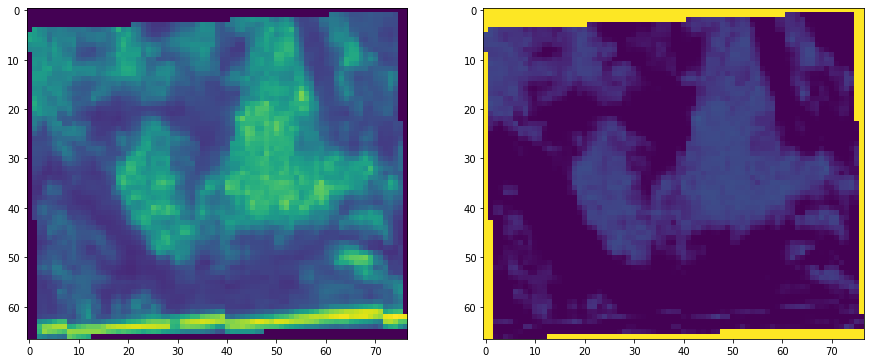

Prediction saved


In [12]:
with tf.device('/cpu:0'):
    start_time = datetime.now()
    n=0
    pred_coord=[]
    tfvstack=[]
    print('starting')
    for y in range(Y_b): #iterate through all pix
        for x in range(X_b):
            pixel=input_img[y,x] #want to create a tile for initial testing
            if pixel.min() !=0:#make sure there are no null pixels in the rgb raster
                pixel = tf.cast(pixel, tf.float32)/65535
                pixel = np.expand_dims(pixel, axis=0)
                pred_coord.append([y,x])#[y,x],[lichenvalue, tile123,tile456,tile789]
                tfvstack.append(pixel)
                n+=1
                if len(tfvstack) >= 10000: #set number of 000s for how frequently you want to process a batch in tf.
                    pred_dataset = tf.data.Dataset.from_tensor_slices(tfvstack) #create a tensorflow dataset
                    result=model.predict(pred_dataset) #pass the whole dataset throught the model
                    for i in range (len(result)): #extract the results and use them to edit 
                        prediction[pred_coord[i][0],pred_coord[i][1]]=result[i]*100
                    pred_coord=[]
                    tfvstack=[]#after processing the batch then delete it and start again
                if str(n)[-5:] == '00000':
                    ctime_time = (datetime.now()-start_time)
                    print('{} pixels processed in {}, {}% done'.format(n,ctime_time,str("%.2f"%(n/totalpix*100))))
    print('Final Pixels')
    pred_dataset = tf.data.Dataset.from_tensor_slices(tfvstack)
    result=model.predict(pred_dataset)
    for i in range (len(result)):
        prediction[pred_coord[i][0],pred_coord[i][1]]=result[i]*100
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    print('{} Pixels processed'.format(str(n)))
    fig, ax = plt.subplots(1, 2, figsize=(15, 15), sharex=False, sharey=False)
    ax[0].imshow(input_img[:,:,2]/3000)
    ax[1].imshow(prediction/100)
    plt.show()
    cv2.imwrite(out_img, prediction)
    print('Prediction saved')